# Praktikum 5 - Day vs Night Image Classification

In [33]:

import os
from zipfile import ZipFile

zip_path = '/mnt/data/images.zip'  # Ubah sesuai lokasi file zip jika diperlukan
extract_to = '/mnt/data/images'    # Default ekstraksi

if os.path.exists(zip_path):
    print(f'Found {zip_path} — extracting to {extract_to} ...')
    os.makedirs(extract_to, exist_ok=True)
    with ZipFile(zip_path, 'r') as zf:
        zf.extractall(extract_to)
    print('Extraction completed.')
else:
    print(f'No archive found at {zip_path}.')
    print('Make sure your images are placed in a folder with structure:')
    print('  images/training/<day|night>/*.jpg')
    print('  images/test/<day|night>/*.jpg')
    print('or extract your zip to /mnt/data/images and update the paths below if needed.')


Found /mnt/data/images.zip — extracting to /mnt/data/images ...
Extraction completed.


In [34]:

# Import libraries
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import pandas as pd
import os

# Define default directories (update if your images are in different location)
# If you extracted to /mnt/data/images, set train_dir = '/mnt/data/images/training/'
train_dir = '/mnt/data/images/images/training'   # relative path (recommended for reproducibility)
test_dir = '/mnt/data/images/images/test'
print('Train dir:', train_dir)
print('Test dir :', test_dir)


Train dir: /mnt/data/images/images/training
Test dir : /mnt/data/images/images/test


In [35]:

def load_dataset(img_dir):
    p = Path(img_dir)
    if not p.exists():
        raise FileNotFoundError(f"Directory {img_dir} not found. Please extract dataset or update the path.")
    dirs = [d for d in p.iterdir() if d.is_dir()]

    img_list = []
    for dir in dirs:
        label = dir.name  # e.g. 'day' or 'night'
        for file in dir.glob('*.jpg'):
            try:
                img = mpimg.imread(file)
            except Exception as e:
                # try with cv2 as fallback
                try:
                    img = cv2.imread(str(file))
                    # cv2 reads in BGR; convert to RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                except:
                    img = None
            if img is not None:
                img_list.append((img, label))
    return img_list

# Safe loader example (won't run until you call it)
# train_img = load_dataset(train_dir)


In [36]:

# Visualization helper and quick checks
def random_img_viz(img_list):
    rand_num = np.random.randint(0, len(img_list))
    img = img_list[rand_num][0]
    label = img_list[rand_num][1]
    plt.imshow(img)
    plt.axis('off')
    print(f'Shape: {img.shape}')
    print(f'Label: {label}')

# Example usage (uncomment after loading)
# random_img_viz(train_img)


In [37]:

# Preprocessing functions
def standarized_input(image, width=1100, height=600):
    # Resize to (width, height). Input image assumed RGB as numpy array.
    std_img = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)
    return std_img

def label_encoder(label):
    # day as 1; night as 0
    return 1 if label.lower() == 'day' else 0

def preprocess(img_list, width=1100, height=600):
    std_img_list = []
    for item in img_list:
        image = item[0]
        label = item[1]
        std_img = standarized_input(image, width=width, height=height)
        img_label = label_encoder(label)
        std_img_list.append((std_img, img_label))
    return std_img_list


In [38]:

# Feature extraction: average brightness (V channel of HSV)
def avg_brightness(image):
    # Expecting image in RGB; convert to HSV using cv2 requires RGB->HSV via cv2.COLOR_RGB2HSV
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    sum_brightness = np.sum(img_hsv[:, :, 2].astype(np.float64))
    area = image.shape[0] * image.shape[1]
    avg = sum_brightness / area
    return avg


In [39]:

def predict_label(img, threshold):
    avg = avg_brightness(img)
    return 1 if avg > threshold else 0

def evaluate(img_list, threshold):
    miss_labels = []
    for file in img_list:
        img = file[0]
        label = file[1]
        pred_label = predict_label(img, threshold)
        if pred_label != label:
            miss_labels.append((img, pred_label, label))
    total_img = len(img_list)
    corr_pred = total_img - len(miss_labels)
    accuracy = corr_pred / total_img
    print(f'Total images: {total_img}')
    print(f'Correct predictions: {corr_pred}')
    print(f'Accuracy: {accuracy:.4f}')
    return accuracy, miss_labels


In [40]:

def extract_avg_bright_feature(img_list):
    avg_list = []
    labels = []
    for img in img_list:
        img_avg = avg_brightness(img[0])
        img_label = img[1]
        avg_list.append(img_avg)
        labels.append(img_label)
    data = np.column_stack((avg_list, labels)).astype(float)
    df = pd.DataFrame(data, columns=['AVG_BRIGHT', 'LABELS'])
    return df

# Example:
# train_avg_img = extract_avg_bright_feature(train_std_img_list)


In [41]:

# SVM classification on the AVG_BRIGHT feature
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def train_and_eval_svm(train_df, test_df):
    X_train = train_df['AVG_BRIGHT'].values.reshape(-1,1)
    y_train = train_df['LABELS'].values
    X_test = test_df['AVG_BRIGHT'].values.reshape(-1,1)
    y_test = test_df['LABELS'].values

    model = SVC()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    acc_train = accuracy_score(y_train, y_train_pred)
    acc_test = accuracy_score(y_test, y_test_pred)

    print(f'Accuracy on train: {acc_train:.4f}')
    print(f'Accuracy on test : {acc_test:.4f}')
    print('\nClassification report (test):')
    print(classification_report(y_test, y_test_pred))
    return model, (acc_train, acc_test), (y_test, y_test_pred)


Loaded 240 training images and 160 test images.

Random sample from training set:
Shape: (600, 1100, 3)
Label: 0

Evaluating simple threshold classifier (threshold=120):
Total images: 240
Correct predictions: 202
Accuracy: 0.8417
Total images: 160
Correct predictions: 139
Accuracy: 0.8688

Train feature shape: (240, 2)
Test feature shape : (160, 2)

Training SVM on AVG_BRIGHT feature...
Accuracy on train: 0.8625
Accuracy on test : 0.9000

Classification report (test):
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90        80
         1.0       0.92      0.88      0.90        80

    accuracy                           0.90       160
   macro avg       0.90      0.90      0.90       160
weighted avg       0.90      0.90      0.90       160



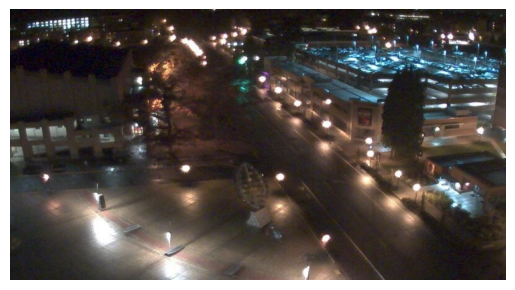

In [42]:

# FULL RUN: load data, preprocess, extract features, threshold eval and SVM
# NOTE: run this cell after ensuring train_dir and test_dir point to correct folders
try:
    train_img = load_dataset(train_dir)
    test_img = load_dataset(test_dir)
    print(f'Loaded {len(train_img)} training images and {len(test_img)} test images.')
except Exception as e:
    raise

# Preprocess (resize + encode)
train_std_img_list = preprocess(train_img)
test_std_img_list = preprocess(test_img)

# Quick visualization
print('\nRandom sample from training set:')
random_img_viz(train_std_img_list)

# Threshold classifier evaluation
print('\nEvaluating simple threshold classifier (threshold=120):')
acc_train, _ = evaluate(train_std_img_list, threshold=120)
acc_test, _ = evaluate(test_std_img_list, threshold=120)

# Extract tabular features
train_avg_img = extract_avg_bright_feature(train_std_img_list)
test_avg_img  = extract_avg_bright_feature(test_std_img_list)
print('\nTrain feature shape:', train_avg_img.shape)
print('Test feature shape :', test_avg_img.shape)

# Train and evaluate SVM on AVG_BRIGHT feature
print('\nTraining SVM on AVG_BRIGHT feature...')
model, (acc_train_svm, acc_test_svm), _ = train_and_eval_svm(train_avg_img, test_avg_img)
